In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

from metric_utils import get_data_metrics, get_model_metrics
from global_utils import get_globals

In [2]:
## Globals
DATA_PATH = get_globals().get('DATA_PATH')
COLORS = get_globals().get('COLORS')
RANDOM_STATE = get_globals().get('RANDOM_STATE')
TEST_SIZE = get_globals().get('TEST_SIZE')

# model params
MAX_DEPTH = get_globals().get('MAX_DEPTH')
ITER = get_globals().get('ITER')
N_JOBS = get_globals().get('N_JOBS')

# cross validation params
N_SPLITS = 5
N_REPEATS = 2
SCORING = get_globals().get('SCORING')

In [3]:
df = pd.read_csv(DATA_PATH)
X, y = df.drop(columns=['Class']), df['Class']

# resampling maethods
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto', random_state=RANDOM_STATE, 
    n_neighbors=n_neighbors, n_jobs=N_JOBS)

# estimators
lrc = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
rfc = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)

# cross validation strategy
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
estimator = Pipeline(
    [('resampling', cnn), ('estimator', lrc)])

grid = GridSearchCV(
    estimator, grid_params, scoring=get_cross_scores(), cv=cv_strategy,
    refit=prefered_metric, n_jobs=N_JOBS, return_train_score=True)
grid.fit(X_train, y_train)

grid_result = cast_scores(grid.cv_results_)
grid_result.update({'exp_id': exp_id})
logger.info(create_message('grid_cv_results', grid_result))

best_params = grid.best_params_
best_params.update({'exp_id': exp_id})
logger.info(create_message('grid_best_params', best_params))

In [5]:
from time import perf_counter

cnn_results = []
for n_neighbors in [1,2,3,4,5]:
    
    start_time = perf_counter()
    
    cnn = CondensedNearestNeighbour(
        sampling_strategy='auto', random_state=RANDOM_STATE, 
        n_neighbors=n_neighbors, n_jobs=N_JOBS)
    X_train_res, y_train_res = cnn.fit_resample(X_train, y_train)
    
    end_time = perf_counter()
    
    cnn_results.append({
        'time': (end_time - start_time) * 1000,
        'id_': n_neighbors, 
        'X_train_res': X_train_res,
        'y_train_res': y_train_res,
        'result':  get_data_metrics(y_train_res, 'train', f'CNN: {n_neighbors}')
    })

In [6]:
df_cnn_result = pd.DataFrame()

for result in cnn_results:
    for class_ in result['result']:
        class_['exp_id'] = result['id_']
    df_result = pd.DataFrame(result['result'])
    df_cnn_result = pd.concat([df_cnn_result, df_result], ignore_index=True)

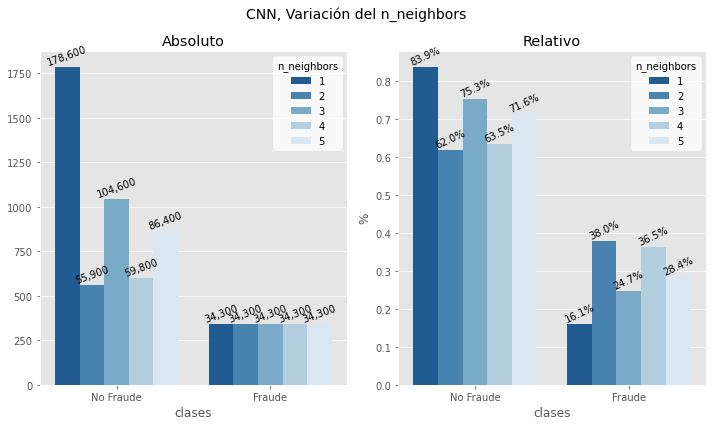

In [7]:
_ = plt.figure(figsize=[10,6])
plt.suptitle(f'CNN, Variación del n_neighbors', fontsize=14)

plt.subplot(1,2,1)
ax = sns.barplot(
    data=df_cnn_result,
    x='class',
    y='count',
    hue='exp_id',
    palette='Blues_r')
plt.title('Absoluto')
plt.xticks(range(2), ['No Fraude', 'Fraude'])
plt.xlabel('clases')
plt.ylabel('')
plt.legend(loc='upper right', frameon=True, title='n_neighbors')\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{int(value):,}' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=20)

plt.subplot(1,2,2)
ax = sns.barplot(
    data=df_cnn_result,
    x='class',
    y='percent',
    hue='exp_id',
    palette='Blues_r')
plt.title('Relativo')
plt.xticks(range(2), ['No Fraude', 'Fraude'])
plt.xlabel('clases')
plt.ylabel('%')
plt.legend(loc='upper right', frameon=True, title='n_neighbors')\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=25)

plt.tight_layout()

In [8]:
lrc = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)

models = [('LR', lrc), ('RFC', rfc)]

ml_result = []
for model_name, model in models:
    for result in cnn_results:
        model.fit(result['X_train_res'], result['y_train_res'])
        y_pred = model.predict(X_test)
        
        exp_id = f'CNN({result["id_"]}) + {model_name}'
        ml_result.append(get_model_metrics(y_test, y_pred, exp_id, True))

In [9]:
df_ml_result = pd.DataFrame(ml_result)
df_ml_result.columns

Index(['is_resampled', 'exp_id', 'f_score', 'recall', 'precision', 'g_mean',
       'roc_auc_score'],
      dtype='object')

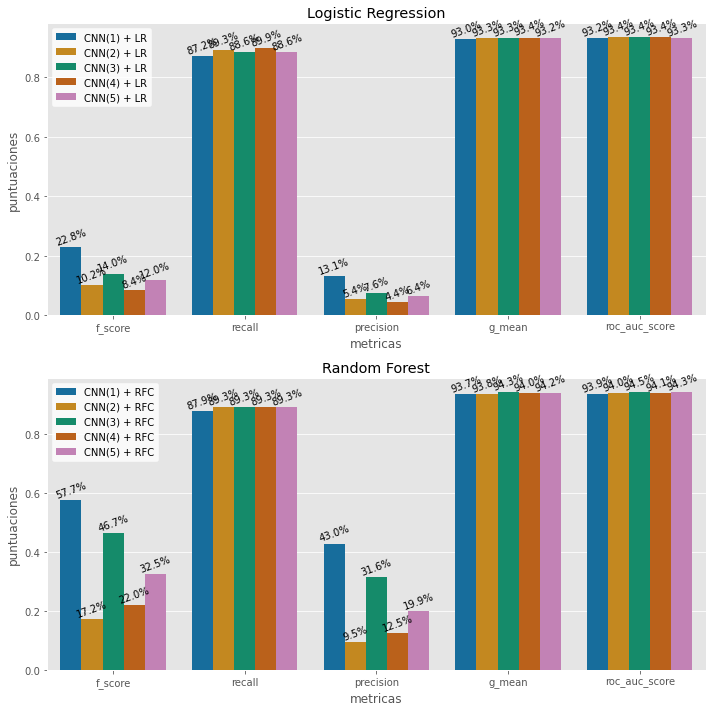

In [10]:
df_melted = df_ml_result.melt(
    id_vars='exp_id',
    value_vars=[
        'f_score', 'recall', 'precision', 'g_mean', 'roc_auc_score'],
    var_name='metrics',
    value_name='scores')

_ = plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
ax = sns.barplot(
    data=df_melted[df_melted['exp_id'].str.contains('LR')],
    x='metrics',
    y='scores',
    hue='exp_id',
    palette='colorblind')
plt.title('Logistic Regression')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='upper left', frameon=True)\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=20)
    
plt.subplot(2,1,2)
ax = sns.barplot(
    data=df_melted[df_melted['exp_id'].str.contains('RFC')],
    x='metrics',
    y='scores',
    hue='exp_id',
    palette='colorblind')
plt.title('Random Forest')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='upper left', frameon=True)\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=20)

plt.tight_layout()

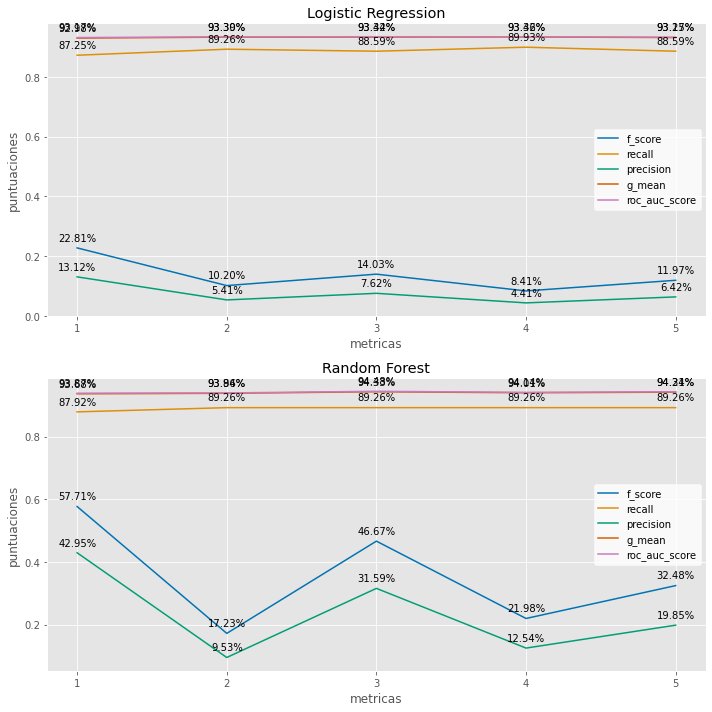

In [11]:
df_melted = df_ml_result.melt(
    id_vars='exp_id',
    value_vars=[
        'f_score', 'recall', 'precision', 'g_mean', 'roc_auc_score'],
    var_name='metrics',
    value_name='scores')
df_melted['n_neighbors'] = df_melted['exp_id'].str.findall('\(([^)]+)').str[0]


_ = plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
ax = sns.lineplot(
    data=df_melted[df_melted['exp_id'].str.contains('LR')],
    x='n_neighbors',
    y='scores',
    hue='metrics',
    palette='colorblind')
plt.title('Logistic Regression')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='center right', frameon=True)\
    .get_frame().set_color('white')
for line in ax.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        label = '{:.2f}%'.format(y_value*100)
        ax.annotate(
            label,(x_value, y_value), 
            xytext=(0, 5),
            textcoords="offset points",
            ha='center', 
            va='bottom')
    
plt.subplot(2,1,2)
ax = sns.lineplot(
    data=df_melted[df_melted['exp_id'].str.contains('RFC')],
    x='n_neighbors',
    y='scores',
    hue='metrics',
    palette='colorblind')
plt.title('Random Forest')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='center right', frameon=True)\
    .get_frame().set_color('white')
for line in ax.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        label = '{:.2f}%'.format(y_value*100)
        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, 5),
            textcoords="offset points",
            ha='center', 
            va='bottom')

plt.tight_layout()

In [12]:
smote_results = []
for k_neighbors in [1,2,3,4,5]:
    
    start_time = perf_counter()
    
    smote = SMOTE(
        sampling_strategy='auto', random_state=RANDOM_STATE, 
        k_neighbors=k_neighbors, n_jobs=N_JOBS)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    end_time = perf_counter()
    
    smote_results.append({
        'time': (end_time - start_time) * 1000,
        'id_': k_neighbors, 
        'X_train_res': X_train_res,
        'y_train_res': y_train_res,
        'result':  get_data_metrics(y_train_res, 'train', f'SMOTE: {k_neighbors}')
    })
    
smote_ml_result = []
for model_name, model in models:
    for result in smote_results:
        model.fit(result['X_train_res'], result['y_train_res'])
        y_pred = model.predict(X_test)
        
        exp_id = f'SMOTE({result["id_"]}) + {model_name}'
        smote_ml_result.append(get_model_metrics(y_test, y_pred, exp_id, True))

In [13]:
df_smote_result = pd.DataFrame(smote_ml_result)
df_smote_result

,is_resampled,exp_id,f_score,recall,precision,g_mean,roc_auc_score
0,True,SMOTE(1) + LR,0.129245,0.919463,0.069508,0.949470,0.949959
1,True,SMOTE(2) + LR,0.077193,0.885906,0.040355,0.925349,0.926227
2,True,SMOTE(3) + LR,0.080219,0.885906,0.042011,0.926007,0.926915
3,True,SMOTE(4) + LR,0.124825,0.899329,0.067067,0.938863,0.939732
4,True,SMOTE(5) + LR,0.125234,0.899329,0.067303,0.938899,0.939770
5,True,SMOTE(1) + RFC,0.866894,0.852349,0.881944,0.923144,0.926084
6,True,SMOTE(2) + RFC,0.861017,0.852349,0.869863,0.923134,0.926073
7,True,SMOTE(3) + RFC,0.859060,0.859060,0.859060,0.926751,0.929418
8,True,SMOTE(4) + RFC,0.842105,0.859060,0.825806,0.926722,0.929386
9,True,SMOTE(5) + RFC,0.847682,0.859060,0.836601,0.926732,0.929397


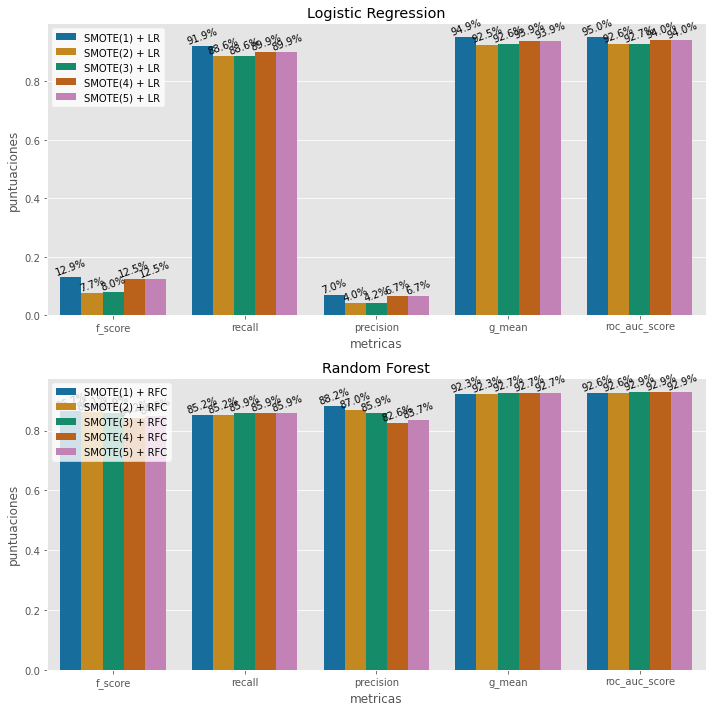

In [14]:
df_smote_melted = df_smote_result.melt(
    id_vars='exp_id',
    value_vars=[
        'f_score', 'recall', 'precision', 'g_mean', 'roc_auc_score'],
    var_name='metrics',
    value_name='scores')

_ = plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
ax = sns.barplot(
    data=df_smote_melted[df_smote_melted['exp_id'].str.contains('LR')],
    x='metrics',
    y='scores',
    hue='exp_id',
    palette='colorblind')
plt.title('Logistic Regression')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='upper left', frameon=True)\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=20)
    
plt.subplot(2,1,2)
ax = sns.barplot(
    data=df_smote_melted[df_smote_melted['exp_id'].str.contains('RFC')],
    x='metrics',
    y='scores',
    hue='exp_id',
    palette='colorblind')
plt.title('Random Forest')
plt.xlabel('metricas')
plt.ylabel('puntuaciones')
plt.legend(loc='upper left', frameon=True)\
    .get_frame().set_color('white')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black', rotation=20)

plt.tight_layout()